In [55]:
import numpy as np
np.random.seed(42)
import sys
import cProfile
import h5py
sys.path.insert(0, '../..')
%reload_ext memory_profiler
%reload_ext autoreload
%autoreload 1
import allel; print(allel.__version__)
%aimport allel.stats.selection

0.21.0.dev0


In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

In [57]:
callset = h5py.File('/data/coluzzi/ag1000g/data/phase1/release/AR3/haplotypes/main/hdf5/ag1000g.phase1.ar3.haplotypes.3R.h5',
                    mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.haplotypes.3R.h5" (mode r)>

In [58]:
n_variants = 1000000
n_samples = 50

In [59]:
h1 = allel.GenotypeArray(callset['3R']['calldata/genotype'][:n_variants, :n_samples]).to_haplotypes()
h1

,0,1,2,3,4,...,95,96,97,98,99
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [60]:
h2 = allel.GenotypeArray(callset['3R']['calldata/genotype'][:n_variants, -n_samples:]).to_haplotypes()
h2

,0,1,2,3,4,...,95,96,97,98,99
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [61]:
pos = callset['3R']['variants/POS'][:n_variants]
pos

array([   1252,    1262,    1271, ..., 3808745, 3808748, 3808749], dtype=int32)

In [62]:
ac1 = h1.count_alleles(max_allele=1)
ac2 = h2.count_alleles(max_allele=1)
ac = allel.AlleleCountsArray(ac1 + ac2)
is_seg = ac.is_segregating() & (ac.min(axis=1) > 1)
h1_seg = h1.compress(is_seg, axis=0)
h2_seg = h2.compress(is_seg, axis=0)
pos_seg = pos.compress(is_seg)
ac_seg = ac.compress(is_seg, axis=0)
ac1_seg = ac1.compress(is_seg, axis=0)
ac2_seg = ac2.compress(is_seg, axis=0)
np.count_nonzero(is_seg)

206253

In [13]:
%%time
score_0min = allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0, include_edges=True, use_threads=False)

CPU times: user 42.6 s, sys: 0 ns, total: 42.6 s
Wall time: 42.6 s


In [63]:
%%time
score = allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0.05, include_edges=True, use_threads=False)

CPU times: user 9.3 s, sys: 0 ns, total: 9.3 s
Wall time: 9.29 s


In [64]:
%%time
score_threaded = allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0.05, include_edges=True, use_threads=True)

CPU times: user 10.1 s, sys: 0 ns, total: 10.1 s
Wall time: 2.61 s


In [11]:
score

array([        nan, -0.34142822, -0.42965751, ...,  0.18381358,
        0.17693078,         nan])

In [12]:
score_threaded

array([        nan, -0.34142822, -0.42965751, ...,  0.18381358,
        0.17693078,         nan])

In [14]:
np.count_nonzero(np.isnan(score)), np.count_nonzero(~np.isnan(score))

(2, 206251)

In [15]:
np.count_nonzero(np.isinf(score)), np.count_nonzero(~np.isinf(score))

(0, 206253)

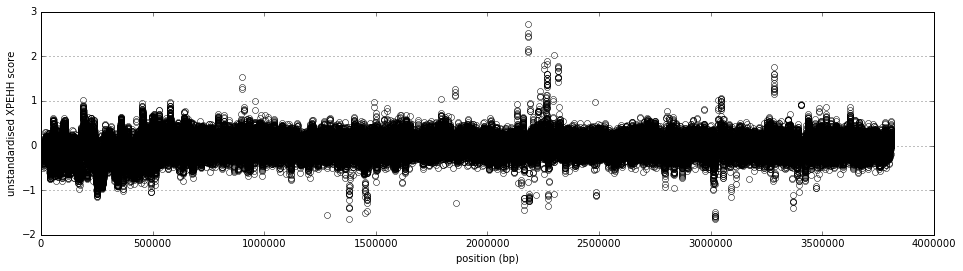

In [16]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('unstandardised XPEHH score');

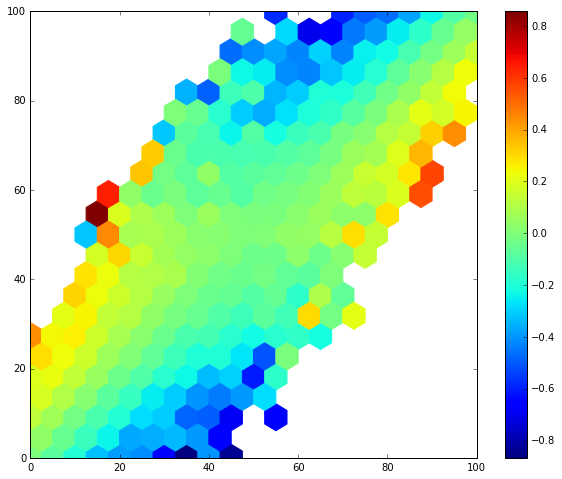

In [17]:
x = ac1_seg[:, 1]
y = ac2_seg[:, 1]
C = score
plt.figure(figsize=(10, 8))
plt.hexbin(x, y, C, gridsize=20)
plt.colorbar();

In [18]:
import scipy as sp
import scipy.stats

In [19]:
bins = np.arange(0, n_samples*2 + 1, 10)
mean_ihs_by_aac, _, _, mean_ihs_bn = sp.stats.binned_statistic_2d(ac1_seg[:, 1], ac2_seg[:, 1], score, 
                                                                  statistic=np.nanmean, bins=bins)
std_ihs_by_aac, _, _, std_ihs_bn = sp.stats.binned_statistic_2d(ac1_seg[:, 1], ac2_seg[:, 1], score, 
                                                                statistic=np.nanstd, bins=bins)

In [20]:
hst, _, _ = np.histogram2d(ac1_seg[:, 1], ac2_seg[:, 1], bins=bins)

In [21]:
hst[-1, -1]

3178.0

In [22]:
hst[0, -1]

0.0

In [23]:
mean_ihs_by_aac[2, -1]

nan

In [24]:
bins

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [25]:
mean_ihs_by_aac.shape

(10, 10)

In [26]:
mean_ihs_by_aac.shape, std_ihs_by_aac.shape

((10, 10), (10, 10))

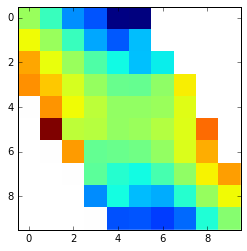

In [27]:
plt.imshow(mean_ihs_by_aac.T, interpolation='none');

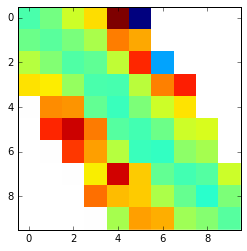

In [28]:
plt.imshow(std_ihs_by_aac.T, interpolation='none');

In [29]:
score_centred = np.zeros_like(score)
score_normed = np.zeros_like(score)

In [30]:
bins

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [31]:
score.shape

(206253,)

In [32]:
score_centred.shape

(206253,)

In [33]:
x = ac1_seg[:, 1]
y = ac2_seg[:, 1]
for i in range(len(bins) - 1):
    for j in range(len(bins) - 1):
        x1 = bins[i]
        x2 = bins[i + 1]
        y1 = bins[j]
        y2 = bins[j + 1]
        if i+1 == len(bins) - 1:
            locx = (x >= x1) & (x <= x2)
        else:
            locx = (x >= x1) & (x < x2)
        if j+1 == len(bins) - 1:
            locy = (y >= y1) & (y <= y2)
        else:
            locy = (y >= y1) & (y < y2)
        loc = locx & locy
        if np.count_nonzero(loc):
            m = mean_ihs_by_aac[i, j]
            s = std_ihs_by_aac[i, j]
            print(i, j, x1, x2, y1, y2, np.count_nonzero(loc), m, s)
            score_centred[loc] = score[loc] - m
            score_normed[loc] = score_centred[loc] / s

0 0 0 10 0 10 152560 -0.00158282797532 0.16970563647
0 1 0 10 10 20 7120 0.12414944979 0.186610034141
0 2 0 10 20 30 450 0.234883093417 0.220657849658
0 3 0 10 30 40 40 0.260985809472 0.258960697624
1 0 10 20 0 10 5915 -0.144807849273 0.188339529044
1 1 10 20 10 20 7955 -0.00267621398344 0.176856253107
1 2 10 20 20 30 2554 0.115199215343 0.196720762369
1 3 10 20 30 40 463 0.190493495588 0.253830134368
1 4 10 20 40 50 70 0.258695459336 0.292221109405
1 5 10 20 50 60 7 0.55931914548 0.335135445361
2 0 20 30 0 10 433 -0.330109323158 0.230604023202
2 1 20 30 10 20 2212 -0.142640155008 0.192488836392
2 2 20 30 20 30 3018 -0.00421095415147 0.172786025853
2 3 20 30 30 40 1408 0.0861379697888 0.205019153767
2 4 20 30 40 50 361 0.123376398031 0.289647363888
2 5 20 30 50 60 97 0.049694924014 0.358526357658
2 6 20 30 60 70 23 0.247725315744 0.327261700848
3 0 30 40 0 10 83 -0.398513781464 0.259529538747
3 1 30 40 10 20 333 -0.301070300333 0.214412586159
3 2 30 40 20 30 1193 -0.112450933846 0.1793

In [34]:
np.count_nonzero(np.isnan(score_centred))

2

In [35]:
np.count_nonzero(np.isnan(score_normed))

3

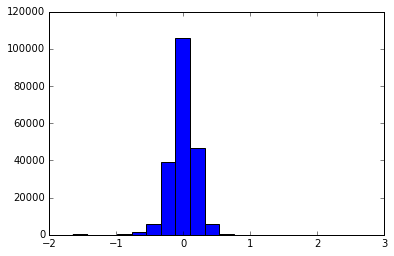

In [38]:
plt.hist(score[~np.isnan(score)], bins=20);

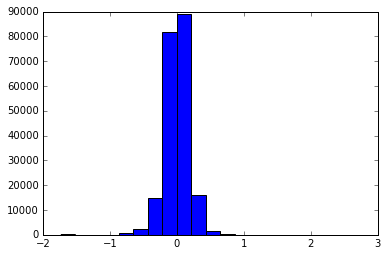

In [37]:
plt.hist(score_centred[~np.isnan(score)], bins=20);

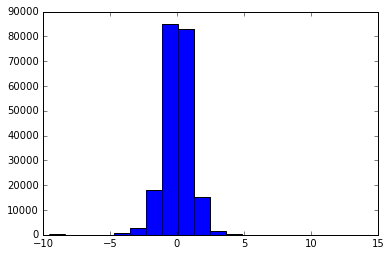

In [39]:
plt.hist(score_normed[~np.isnan(score_normed)], bins=20);

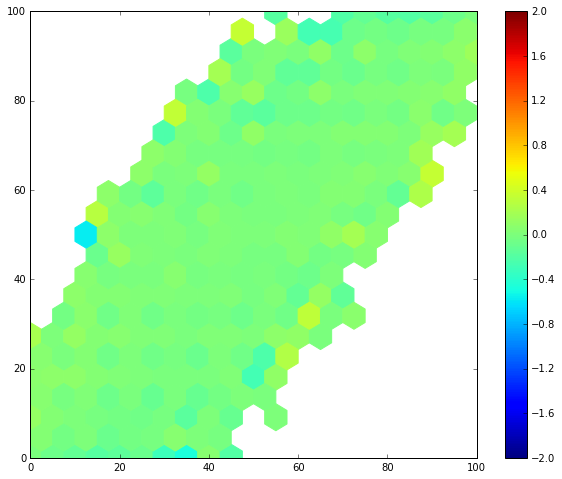

In [40]:
x = ac1_seg[:, 1]
y = ac2_seg[:, 1]
C = score_centred
plt.figure(figsize=(10, 8))
plt.hexbin(x, y, C, gridsize=20, vmin=-2, vmax=2)
plt.colorbar();

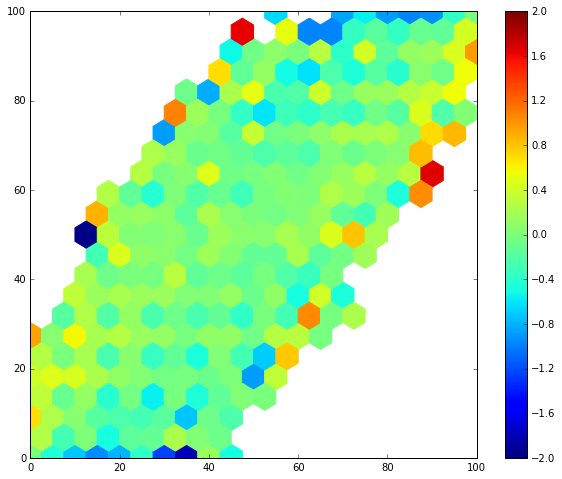

In [41]:
x = ac1_seg[:, 1]
y = ac2_seg[:, 1]
C = score_normed
plt.figure(figsize=(10, 8))
plt.hexbin(x, y, C, gridsize=20, vmin=-2, vmax=2)
plt.colorbar();

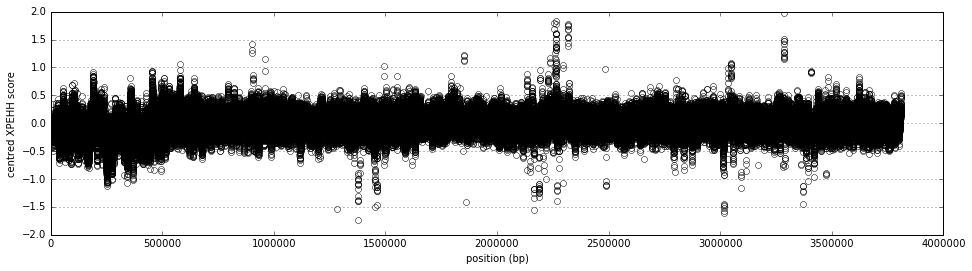

In [42]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score_centred, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('centred XPEHH score')
plt.ylim(-2, 2);

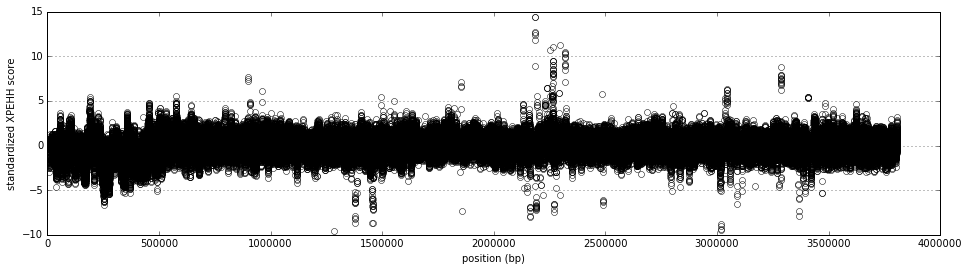

In [44]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score_normed, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('standardized XPEHH score');

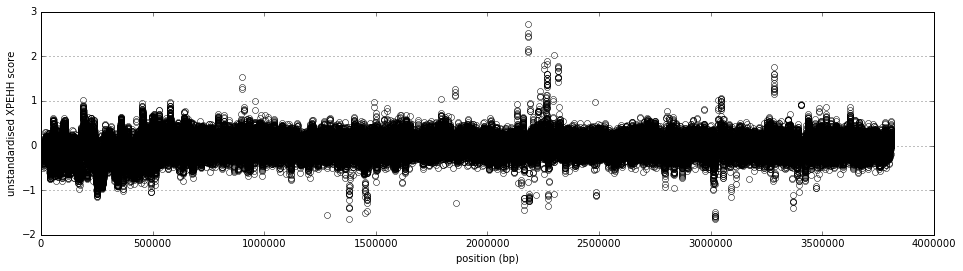

In [45]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('unstandardised XPEHH score');

In [46]:
cProfile.run('allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0.05, include_edges=True, use_threads=False)', sort='time')

         140 function calls in 11.329 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        4   11.317    2.829   11.317    2.829 stats.pyx:516(ihh_scan_int8)
        1    0.011    0.011   11.329   11.329 selection.py:255(xpehh)
        9    0.000    0.000    0.000    0.000 {built-in method numpy.core.multiarray.array}
        4    0.000    0.000    0.000    0.000 stringsource:985(memoryview_fromslice)
        1    0.000    0.000   11.329   11.329 {built-in method builtins.exec}
        1    0.000    0.000   11.329   11.329 <string>:1(<module>)
       20    0.000    0.000    0.000    0.000 stringsource:341(__cinit__)
        4    0.000    0.000   11.317    2.829 {allel.opt.stats.ihh_scan_int8}
        4    0.000    0.000    0.000    0.000 ndarray.py:1783(__array_finalize__)
        2    0.000    0.000    0.000    0.000 ndarray.py:1810(__getitem__)
        7    0.000    0.000    0.000    0.000 numeric.py:414(asarray)
     

## Gap handling

In [35]:
loc_variants = slice(6000000, 8000000, 1)
n_samples = 50

h1 = allel.GenotypeArray(callset['3R']['calldata/genotype'][loc_variants, :n_samples]).to_haplotypes()
h2 = allel.GenotypeArray(callset['3R']['calldata/genotype'][loc_variants, -n_samples:]).to_haplotypes()

In [36]:
pos = callset['3R']['variants/POS'][loc_variants]
pos

array([25967325, 25967327, 25967328, ..., 36036863, 36036865, 36036866], dtype=int32)

In [37]:
ac1 = h1.count_alleles(max_allele=1)
ac2 = h2.count_alleles(max_allele=1)
ac = allel.AlleleCountsArray(ac1 + ac2)
is_seg = ac.is_segregating() & (ac.min(axis=1) > 10)
h1_seg = h1.compress(is_seg, axis=0)
h2_seg = h2.compress(is_seg, axis=0)
pos_seg = pos.compress(is_seg)
ac_seg = ac.compress(is_seg, axis=0)
ac1_seg = ac1.compress(is_seg, axis=0)
ac2_seg = ac2.compress(is_seg, axis=0)
np.count_nonzero(is_seg)

145412

In [38]:
def plot_score_gap(score, pos, ylim=(-7, 7)):

    fig = plt.figure(figsize=(16, 4))

    ax = fig.add_subplot(111)
    ax.plot(pos, score, linestyle=' ', marker='o', mfc='none')
    ax.grid(axis='y')
    ax.set_xlabel('position (bp)')
    ax.set_ylabel('score')
    ax.set_ylim(*ylim)

    ax = ax.twinx()
    x = (pos[:-1] + pos[1:]) / 2
    y = np.diff(pos)
    ax.plot(x, y)
    ax.set_ylabel('gap size (bp)')
    ax.autoscale(axis='x', tight=True);

In [39]:
score_unadjusted = allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0.05, max_gap=-1, clip_gap=-1)

In [50]:
score_gap_adjusted = allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0.05, max_gap=200000, clip_gap=1000)

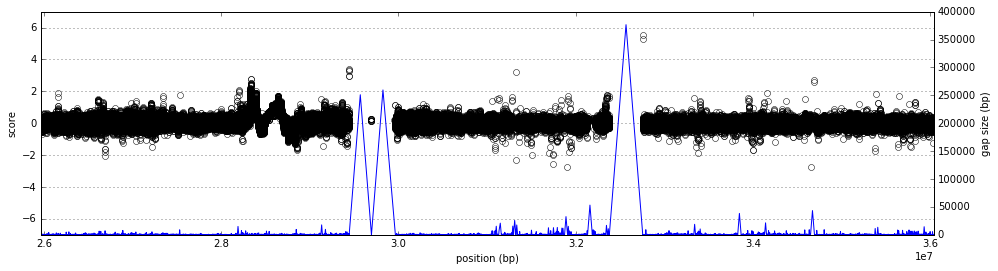

In [51]:
plot_score_gap(score_unadjusted, pos_seg)

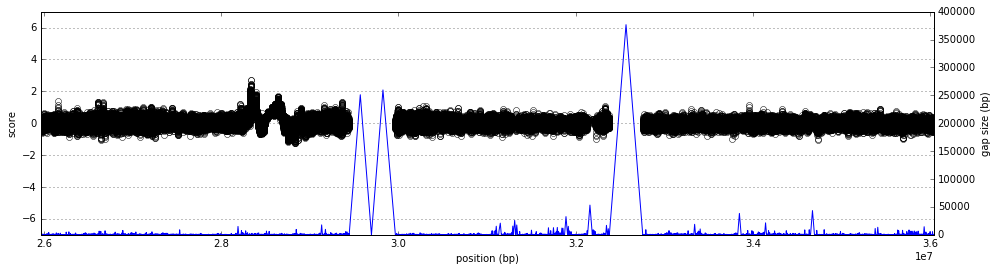

In [52]:
plot_score_gap(score_gap_adjusted, pos_seg)

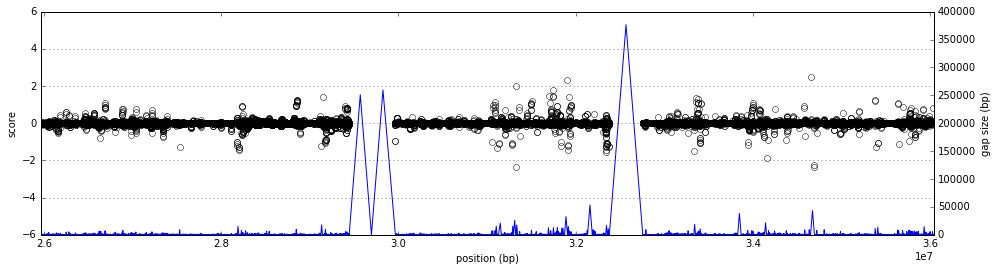

In [53]:
plot_score_gap(score_gap_adjusted - score_unadjusted, pos_seg, ylim=(-6, 6))

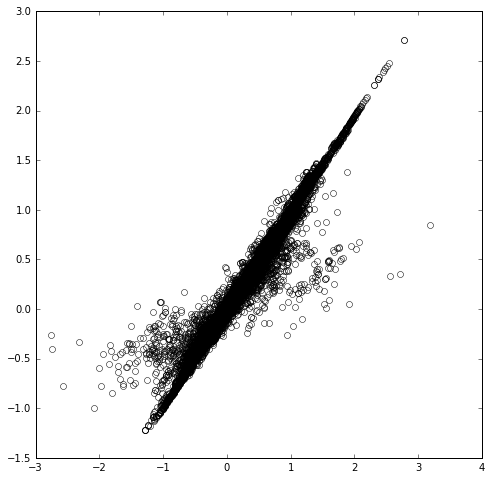

In [54]:
plt.figure(figsize=(8, 8))
plt.plot(score_unadjusted, score_gap_adjusted, marker='o', mfc='none', linestyle=' ');